In [32]:
from NeuralNetwork import Perceptron, ANN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Training a single perceptron with the logic gate functions

We first test a single Perceptron, the simplest unit in Deep learning. We check its performance with the logic gate functions. First, the AND function:

In [33]:
X = np.array([
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]
    ])
d = np.array([0, 0, 0, 1])

epochs = 10

perceptron = Perceptron(input_size=2, bias=-1, epochs=epochs)
errors = perceptron.train(X, d)
print(perceptron.weights) # print weight vector. E.g., [-5, 4, 3] = -5 for bias, w_1=4, w_2=3

[0.42523103 0.4523005 ]


Let's plot the error over the epochs of our perceptron learning the AND function:

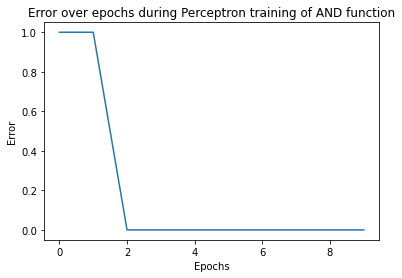

In [34]:
epoch_names = [i for i in range(epochs)]

plt.plot(epoch_names, errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error over epochs during Perceptron training of AND function')
plt.show()

Now we test the OR function:

In [35]:
X = np.array([
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]
    ])
d = np.array([0, 1, 1, 1])

errors = perceptron.train(X, d)
print(perceptron.weights) # print weight vector. E.g., [-3, 2, 1] = -3 for bias, w_1=2, w_2=1

[0.52523103 0.6523005 ]


Let's plot the error over the epochs of our perceptron learning the OR function:

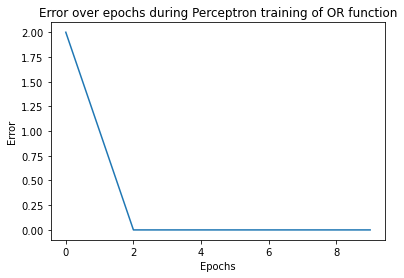

In [36]:
epoch_names = [i for i in range(epochs)]

plt.plot(epoch_names, errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error over epochs during Perceptron training of OR function')
plt.show()

Finally, we test the XOR function:

In [37]:
X = np.array([
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]
    ])
d = np.array([0, 1, 1, 0])

errors = perceptron.train(X, d)
print(perceptron.weights) # print weight vector. E.g., [-3, 2, 1] = -3 for bias, w_1=2, w_2=1

[0.12523103 0.2523005 ]


Let's plot the error over the epochs of our perceptron learning the XOR function:

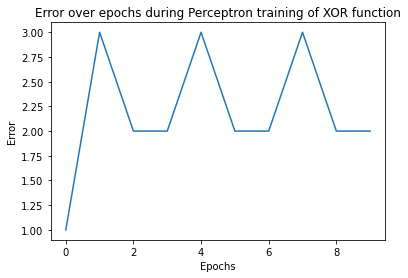

In [38]:
epoch_names = [i for i in range(epochs)]

plt.plot(epoch_names, errors)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error over epochs during Perceptron training of XOR function')
plt.show()

Both AND and OR functions are linearly separable functions, hence the Perceptron can learn them. This is easily checked because the error becomes 2 after a few epochs in both cases. However, XOR is not linear, hence the Perceptron fails when learning it. Notice the error in the graph never converges to 0.0.

# Training

Now we will develop the entire MLP network. First, we must train the network.

To ensure unbiased estimate of performance, we will divide the data into training set (~70% of the data), validation set (~15%) and test set (~15%), ensuring that the three sets are IID.

First, this is the helper method we use to split the data:

In [39]:
def vectorized_result(j, num_classes):
    """
    Perform one-hot encoding to labels starting from 1. That is, we return a ndarray of the same shape as the predictions where we map the label j to the (j-1)th position, as Python counts from 0.
    :param j: the class prediction
    :param num_classes: the total amount of classes
    :return: The one-hot encoding of the j class
    """
    e = np.zeros((num_classes, 1))
    e[j - 1] = 1.0
    return e

In [40]:
def plot_accuracy(input_data: list, size_train, size_test):
    # function to visualize a learning process

    plt.plot([i[0] / size_train * 100 for i in input_data], label="Training data")
    plt.plot([i[1] / size_test * 100 for i in input_data], label="Validation data")

    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy')

    plt.title('Accuracy on data per epoch')
    plt.grid()

    plt.legend()

    # format y-axis tick labels with a "%" symbol and integer values
    fmt = mtick.FuncFormatter(lambda x, pos: '{:.0f}%'.format(x))
    plt.gca().yaxis.set_major_formatter(fmt)

    # set y-axis tick locator to FixedLocator to avoid the warning
    plt.gca().yaxis.set_major_locator(mtick.FixedLocator(plt.gca().get_yticks()))

In [41]:
def plot_loss(input_data: list):

    plt.plot([i[0] for i in input_data], label="Training loss")
    plt.plot([i[1] for i in input_data], label="Validation loss")

    plt.xlabel('Epoch number')
    plt.ylabel('Loss')

    plt.title('Loss on data per epoch')
    plt.grid()

    plt.legend()

In [42]:
def plot_loss1(input_data: list):

    plt.plot([i[0] for i in input_data], label="Training loss")

    plt.xlabel('Epoch number')
    plt.ylabel('Loss')

    plt.title('Loss on training data per epoch')
    plt.grid()

    # plt.yticks([0.5, 0.75, 1, 1.1, 1.15])

    plt.legend()

Now, we split the data:

In [43]:
# Variables
n_features = 10
n_classes = 7
# Let's now use as amount of hidden neurons the mean of number of features and classes
n_hidden = int((n_features + n_classes) / 2) # = 8

# Load the features and labels data as pandas dataframes
features_df = pd.read_csv('./../data/features.txt', header=None)
labels_df = pd.read_csv('./../data/targets.txt', header=None)
unknown_df = pd.read_csv('./../data/unknown.txt', header=None)

# Convert the dataframes to numpy arrays
features = np.array(features_df)
# Reshape the features array to have shape (n_features, 1)
features = [np.reshape(x, (n_features, 1)) for x in features]

labels = np.array(labels_df)
# Obtain the vectorized option
labels = [vectorized_result(y, n_classes) for y in labels]

# Combine the features and labels arrays into a list of tuples
data = [(x, y) for x, y in zip(features, labels)]

# Shuffle the data randomly
np.random.shuffle(data)

# Split the data into training, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

Now that we have the training, validation, and test set, we can train the network. As this is the first time we are training the network, we will use arbitrary values (that make sense). Later we will cross validate to find the most optimal ones. Moreover, we use regularization techniques such as L2 and early stopping, and instead of using the common SGD we use the Adam algorithm. This is because it generally provides a better performance.

We will also use the Softmax function in the output layer (as this is recommended for multi-class classification) and for the hidden layers the ReLU activation function (the standard nowadays, as it converges faster and in general better than sigmoid and tanh).

In [44]:
net = ANN([n_features, n_hidden, n_classes])
train_accuracy, val_accuracy, train_loss, val_loss = net.sgd(train_data, learning_rate=0.1, epochs=50, reg_param=0, validation_data=val_data, print_progress=True, early_stopping=False, adam_active=False)

Epoch 0 -> Train accuracy: 4763 / 5497, Validation accuracy: 1020 / 1178
Epoch 0 -> Train loss: 0.43543148384546787, Validation loss: 0.4337130483789216
Epoch 1 -> Train accuracy: 4884 / 5497, Validation accuracy: 1052 / 1178
Epoch 1 -> Train loss: 0.3339121032264955, Validation loss: 0.3306240477224543
Epoch 2 -> Train accuracy: 4950 / 5497, Validation accuracy: 1064 / 1178
Epoch 2 -> Train loss: 0.28991722415820187, Validation loss: 0.2934386919478678
Epoch 3 -> Train accuracy: 5016 / 5497, Validation accuracy: 1071 / 1178
Epoch 3 -> Train loss: 0.254438119414641, Validation loss: 0.2656548176749415
Epoch 4 -> Train accuracy: 5006 / 5497, Validation accuracy: 1073 / 1178
Epoch 4 -> Train loss: 0.25487806735426893, Validation loss: 0.26355588244727224
Epoch 5 -> Train accuracy: 5022 / 5497, Validation accuracy: 1071 / 1178
Epoch 5 -> Train loss: 0.24495445728247228, Validation loss: 0.25247404680255037
Epoch 6 -> Train accuracy: 5016 / 5497, Validation accuracy: 1077 / 1178
Epoch 6 ->

Let's plot the accuracy of our network using Adam algorithm without early stopping. Note we plot for the training data and the validation data:

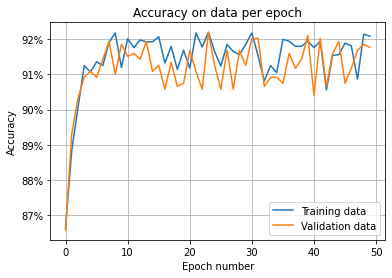

In [45]:
plot_accuracy(list(zip(train_accuracy, val_accuracy)), len(train_data), len(val_data))

Plotting the loss on the training and validation data to observe under- or over-fitting:

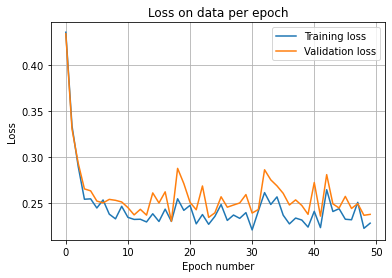

In [46]:
plot_loss(list(zip(train_loss, val_loss)))

Now we view the training loss alone:

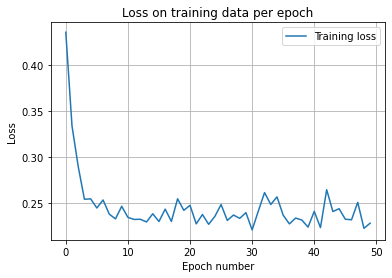

In [47]:
plot_loss1(list(zip(train_loss, val_loss)))

Finally, we check the generalization performance of our network by evaluating how the network performs with the test set:

In [48]:
res = net.evaluate(test_data)
print("The accuracy on the test data is: ", res / len(test_data))

The accuracy on the test data is:  0.916030534351145


We have been using arbitrary parameters for our network. Now we will use cross validation to find the most optimal parameters.

First, let's generate a plot of the final performance versus the number of hidden neurons in the network (using cross validation). We turn off Adam and use simple SGD so the other parameters (like momentum and learning rate) are not modified while training (adam adapts the learning rate over epochs).

Average Accuracy for 4 hidden neurons is 77.43328335832084
Average Accuracy for 7 hidden neurons is 89.79760119940032
Average Accuracy for 8 hidden neurons is 88.04497751124437
Average Accuracy for 9 hidden neurons is 90.81559220389805
Average Accuracy for 10 hidden neurons is 91.40179910044978
Average Accuracy for 11 hidden neurons is 90.78860569715141
Average Accuracy for 15 hidden neurons is 91.9655172413793
Average Accuracy for 30 hidden neurons is 92.34182908545726


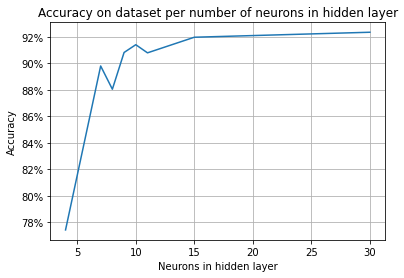

In [47]:
train_val_data = data[:train_size + val_size]

validation_errors = net.cross_validate_neurons(train_val_data, 10, [4, 7, 8, 9, 10, 11, 15, 30], epochs=10)
plt.plot([4, 7, 8, 9, 10, 11, 15, 30], validation_errors)
plt.xlabel('Neurons in hidden layer')
plt.ylabel('Accuracy')

plt.title('Accuracy on dataset per number of neurons in hidden layer')
plt.grid()

# format y-axis tick labels with a "%" symbol and integer values
fmt = mtick.FuncFormatter(lambda x, pos: '{:.0f}%'.format(x))
plt.gca().yaxis.set_major_formatter(fmt)

# set y-axis tick locator to FixedLocator to avoid the warning
plt.gca().yaxis.set_major_locator(mtick.FixedLocator(plt.gca().get_yticks()))

Using the elbow method, the optimal number of chosen neurons is 9. For more than 9 neurons, the accuracy slightly increases, but the computation costs also increase. Thus, 9 neurons in the hidden layer is a good hyperparameter.

Now we use cross validation to pick the best learning rate to start with the Adam algorithm.

Average Accuracy for learning rate 0.001 is 89.47026486756621
Average Accuracy for learning rate 0.01 is 91.9735132433783
Average Accuracy for learning rate 0.05 is 88.77161419290354
Average Accuracy for learning rate 0.1 is 86.41929035482259


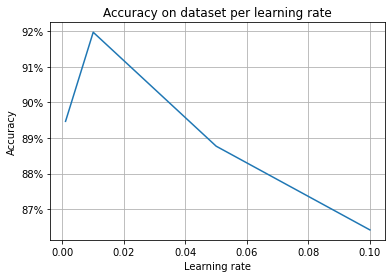

In [37]:
validation_errors = net.cross_validate_learning_rates(train_val_data, 10, 9, [0.001, 0.01, 0.05, 0.1], epochs=30)
plt.plot([0.001, 0.01, 0.05, 0.1], validation_errors)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')

plt.title('Accuracy on dataset per learning rate')
plt.grid()

# format y-axis tick labels with a "%" symbol and integer values
fmt = mtick.FuncFormatter(lambda x, pos: '{:.0f}%'.format(x))
plt.gca().yaxis.set_major_formatter(fmt)

# set y-axis tick locator to FixedLocator to avoid the warning
plt.gca().yaxis.set_major_locator(mtick.FixedLocator(plt.gca().get_yticks()))

As we can see from the graph above, the best learning rate is 0.01

Finally, we use cross validation to pick the best regularization parameter:

Average Accuracy for eta 0 is 91.62368815592204
Average Accuracy for eta 0.001 is 91.83958020989506
Average Accuracy for eta 0.01 is 91.15742128935533
Average Accuracy for eta 0.1 is 91.4767616191904


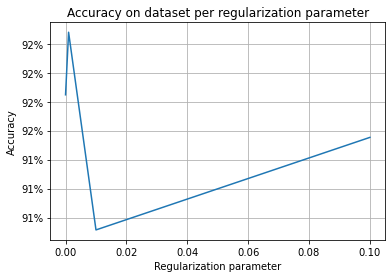

In [38]:
validation_errors = net.cross_validate_eta(train_val_data, 10, 9, 0.01, [0, 0.001, 0.01, 0.1], epochs=10)
plt.plot([0, 0.001, 0.01, 0.1], validation_errors)
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')

plt.title('Accuracy on dataset per regularization parameter')
plt.grid()

# format y-axis tick labels with a "%" symbol and integer values
fmt = mtick.FuncFormatter(lambda x, pos: '{:.0f}%'.format(x))
plt.gca().yaxis.set_major_formatter(fmt)

# set y-axis tick locator to FixedLocator to avoid the warning
plt.gca().yaxis.set_major_locator(mtick.FixedLocator(plt.gca().get_yticks()))

As we can see from the graph above, the best eta is 0.001

Having all the optimal hyperparameters, now we can train the network on these parameters and evaluate its performance on test data.

In [49]:
net = ANN([n_features, 9, n_classes])
train_accuracy, val_accuracy, train_loss, val_loss = net.sgd(train_data, learning_rate=0.001, epochs=50, reg_param=0.001, validation_data=val_data, print_progress=True, early_stopping=True, adam_active=True)

Epoch 0 -> Train accuracy: 3690 / 5497, Validation accuracy: 782 / 1178
Epoch 0 -> Train loss: 1.1341777378261275, Validation loss: 1.119071791101913
Epoch 1 -> Train accuracy: 4723 / 5497, Validation accuracy: 1007 / 1178
Epoch 1 -> Train loss: 0.6466411807562745, Validation loss: 0.6395673869618115
Epoch 2 -> Train accuracy: 4917 / 5497, Validation accuracy: 1050 / 1178
Epoch 2 -> Train loss: 0.4295830795401972, Validation loss: 0.4264785529689822
Epoch 3 -> Train accuracy: 4981 / 5497, Validation accuracy: 1070 / 1178
Epoch 3 -> Train loss: 0.33133027471340387, Validation loss: 0.3334926343778945
Epoch 4 -> Train accuracy: 5032 / 5497, Validation accuracy: 1076 / 1178
Epoch 4 -> Train loss: 0.2853644517596229, Validation loss: 0.28879731149547305
Epoch 5 -> Train accuracy: 5047 / 5497, Validation accuracy: 1079 / 1178
Epoch 5 -> Train loss: 0.26016933205031745, Validation loss: 0.26444499253810977
Epoch 6 -> Train accuracy: 5060 / 5497, Validation accuracy: 1085 / 1178
Epoch 6 -> Tr

Now the accuracy on the training and validation set is:

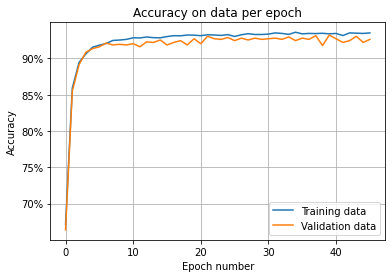

In [50]:
plot_accuracy(list(zip(train_accuracy, val_accuracy)), len(train_data), len(val_data))

Now we plot the loss on both the training and validation set

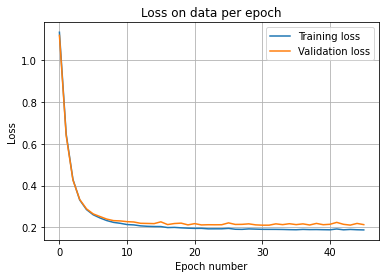

In [51]:
plot_loss(list(zip(train_loss, val_loss)))

Now we get an accuracy on the test set of:

In [52]:
res = net.evaluate(test_data)
print("The accuracy on the test data is: ", res / len(test_data))

The accuracy on the test data is:  0.9372349448685326


We train the network 10 times with different initial weights, to see how the weight initialization impact the performance.

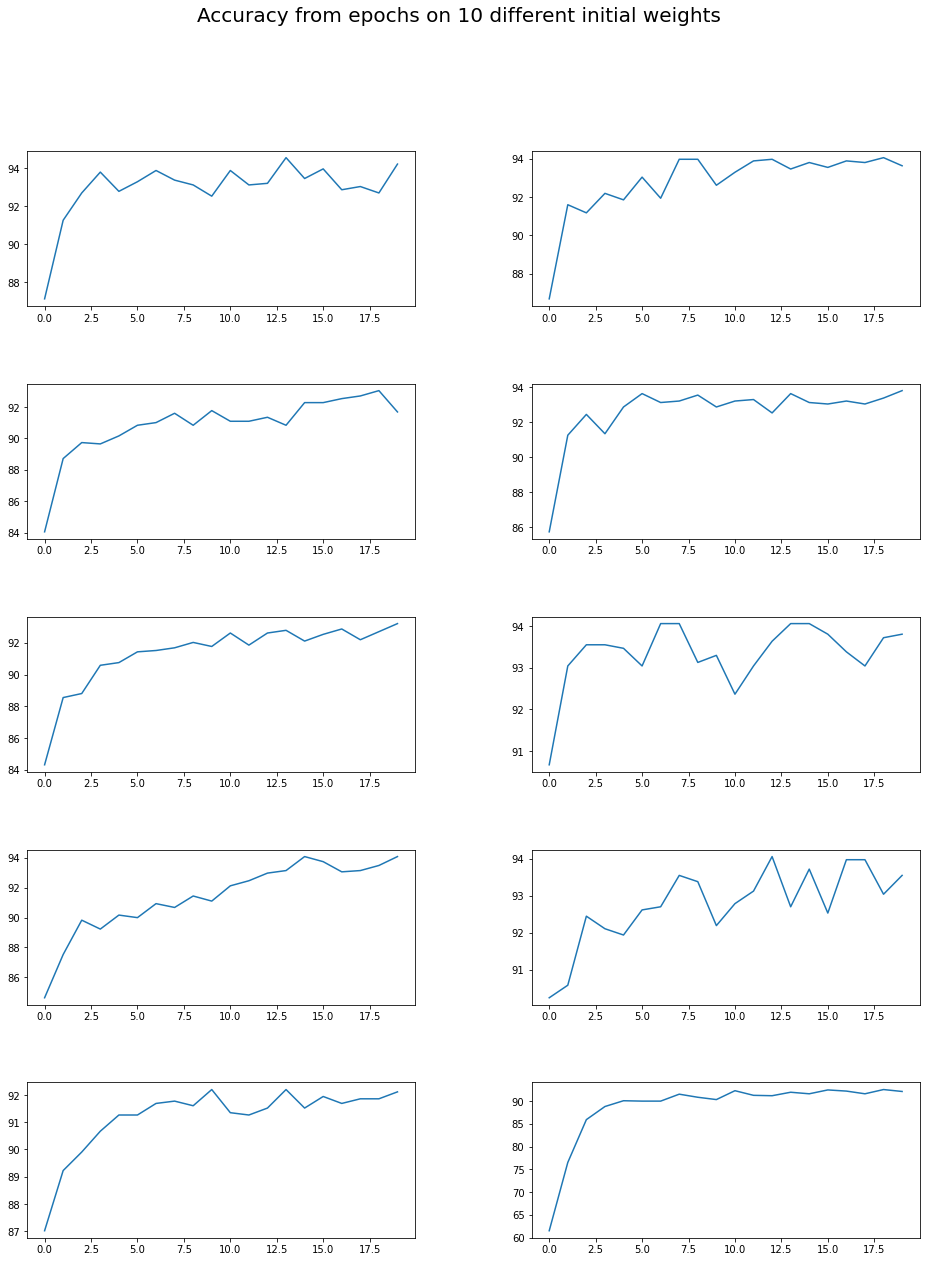

In [48]:
fig, axis = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
fig.suptitle("Accuracy from epochs on 10 different initial weights", fontsize=20)

for row in axis:
    for column in row:
        net = ANN([n_features, 9, n_classes])
        train_accuracy, val_accuracy, train_loss, val_loss = net.sgd(train_data, batch_size=20, learning_rate=0.1, epochs=20, validation_data=test_data)
        column.plot([i / len(test_data) * 100 for i in val_accuracy])

# Adjust spacing
fig.subplots_adjust(hspace=0.5, wspace=0.3)


plt.show()

Next, we output the predictions for the unknown dataset to a txt file.

In [53]:
unknown = np.array(unknown_df)
unknown = [np.reshape(x, (n_features, 1)) for x in unknown]
output = []
for features in unknown:
    output.append(int(net.predict(features)))

output_file_name = "05_classes.txt"
txt = ','.join([str(x) for x in output])

#assert if output is correct
for x, y in zip(output, txt.split(',')):
    assert(x == int(y))
# open file for writing
with open(output_file_name, 'w') as f:
    f.write(txt)

Finally, we create a confusion matrix constructed on the test set

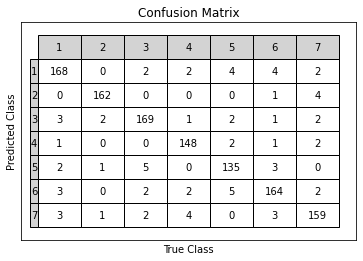

In [54]:
# create 8x8 table with all cells empty
#one row and one column added to include titles
data = [[0]*7 for _ in range(7)]

for i in range(len(test_data)):
    prediction = net.predict(test_data[i][0])
    label = np.argmax(test_data[i][1])
    data[prediction - 1][label] += 1

# create table with cell values and formatting
fig, ax = plt.subplots()
labels = ['1', '2', '3', '4', '5', '6', '7']
colors = ['lightgray'] * len(labels)
table = ax.table(cellText=data, cellLoc='center', rowLabels = labels, rowColours=colors, colLabels = labels, colColours=colors, loc='center')

# set axis labels
ax.set_title('Confusion Matrix', y = 1)
ax.set_xlabel('True Class')
ax.set_ylabel('Predicted Class')
ax.set_xticks([])
ax.set_yticks([])

table.scale(0.9, 2)

table.auto_set_font_size(True)

plt.show()